# Model inference

After training a model starting from Mapillary data in a [previous notebook](./4_model-training.ipynb), one will exploit it by doing inference on unknown images.

## Introduction

First some useful dependencies are loaded:

In [29]:
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

%matplotlib inline

In [27]:
from deeposlandia import inference, semantic_segmentation, utils

So as to recover a model (for instance, the one which has been trained in notebook [dedicated to training](./4_model-training.ipynb)), we have to define a bunch of variables:

In [3]:
DATAPATH = "../data"
DATASET = "mapillary"
IMG_SIZE = 128
MODEL = "semantic_segmentation"
INSTANCE_NAME = "demo"
NETWORK = "simple"
DROPOUT = 1.0
PREPROCESS_FOLDER = utils.prepare_preprocessed_folder(DATAPATH, DATASET, IMG_SIZE, "aggregated")
OUTPUT_FOLDER = utils.prepare_output_folder(DATAPATH, DATASET, MODEL, INSTANCE_NAME)

In [26]:
train_config = utils.read_config(PREPROCESS_FOLDER["training_config"])
labels = train_config["labels"]
nb_labels = len(labels)

For displaying purpose, we define a small function that will depicts the original image, the ground-truth labels and the predicted labels.

In [7]:
def plot_prediction(input_data, prediction):
    """Plot semantic segmentation result on the image provided as an example
    
    Parameters
    ----------
    input_data : str
        Filepath of the input image
    prediction : np.array
        Predicted output, as a numpy array with dimensions that correspond to input image
    
    """
    ground_truth = input_data.replace(".jpg", ".png").replace("images/", "labels/")
    f, ax = plt.subplots(1, 4, figsize=(8, 4))
    ax[0].imshow(Image.open(input_data))
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].imshow(Image.open(ground_truth))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[2].imshow(Image.fromarray(prediction, 'RGB'))
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    ax[3].barh([i['id'] for i in labels], 1, color=[[j/256 for j in i['color']] for i in labels])
    [ax[3].text(0.25, i['id'], i['name']) for i in labels]
    ax[3].get_xaxis().set_visible(False)
    ax[3].get_yaxis().set_visible(False)
    plt.tight_layout()

## Build a model from instance

As a first important step, we have to build a Keras model that corresponds to the instance of interest.

In [30]:
network = semantic_segmentation.SemanticSegmentationNetwork(INSTANCE_NAME,
                                                            IMG_SIZE,
                                                            nb_labels)
model = Model(network.X, network.Y)

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 13)      0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 128, 128, 32)      3776      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_activation (Activation (None, 128, 128, 32)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2_conv (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2_bn (BatchNormalization (None, 64, 64, 64)        256       
__________

For instance, this model still has its initialization weights, no training effort has been done.

## Do inference when model is untrained

We could of course try to predict the labels of an image without training the model; that will be our witness case.

To do such an experimentation, we pick a random image in the validation dataset. This image has been showed to the model during validation process, so it is not a good idea in itself; however let's consider that is satisfying, as the model has not been trained with it.

In [11]:
image_filename = os.listdir(os.path.join(PREPROCESS_FOLDER["validation"], "images"))[0]
image_filepath = os.path.join(PREPROCESS_FOLDER["validation"], "images", image_filename)
image = inference.extract_images([image_filepath])

The last cell provides us the image pixels as a `numpy.array`. We then can try to predict its labels.

In [13]:
y_raw_pred = model.predict(image)
y_raw_pred.shape

We get a valid semantic segmentation output, however some remaining work is still to do, as we want an image by way of output.

First we will recover the predicted labels, amongst all available dataset labels. Then, we will rebuild an output image by substituting label ids with corresponding colors, as defined in the dataset configuration file.

In [16]:
predicted_labels = np.argmax(y_raw_pred, axis=3)
predicted_image = np.zeros(shape=np.append(predicted_labels.shape, 3), dtype=np.int8)
for i in range(nb_labels):
    predicted_image[predicted_labels == i] = train_config["labels"][i]["color"]
predicted_image.shape

And...tada! We may display the result:

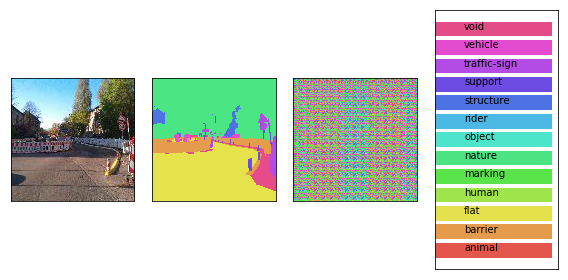

In [18]:
plot_prediction(image_filepath, predicted_image[0])

No surprise here: we did not train the model. Consequently, the output is just a picture composed of random labels...

## Recover trained model weights

How to do better? We will first recover the trained weights that we got in the [previous notebook](./4_model-training.ipynb), after 10 training epochs.

In [19]:
model.load_weights(os.path.join(OUTPUT_FOLDER, "checkpoint-epoch-010.h5"))

## Do inference with trained model

Now it should be better. We first rebuild the output image, as previously.

In [20]:
y_raw_pred = model.predict(image)
predicted_labels = np.argmax(y_raw_pred, axis=3)
predicted_image = np.zeros(shape=np.append(predicted_labels.shape, 3), dtype=np.int8)
for i in range(nb_labels):
    predicted_image[predicted_labels == i] = train_config["labels"][i]["color"]

And, let's display the output:

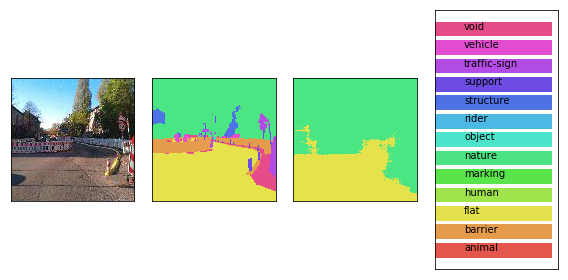

In [21]:
plot_prediction(image_filepath, predicted_image[0])

Hehe, that is far better! The model is able to understand that the image bottom corresponds to `flat` pixels, and we can see the road on the original image. Then the model recognizes `nature` pixels at the top of the image (sky, vegetation). However, a lot of details are missed, as the other labels are not found.

## And with a little more training?

Training a model only during 10 epochs seems quite unsufficient. Maybe better results could be achieved with some additional steps. Let's consider a new training process, with 30 steps, done offline. We can explore the output folder to see that the best training performance was got after 29 epochs.

In [22]:
os.listdir(OUTPUT_FOLDER)

['checkpoint-epoch-010.h5',
 'checkpoint-epoch-001.h5',
 'checkpoint-epoch-029.h5',
 'checkpoint-epoch-002.h5',
 'checkpoint-epoch-006.h5',
 'checkpoint-epoch-007.h5',
 'checkpoint-epoch-003.h5']

Hence, the corresponding weights are loaded into the model.

In [23]:
model.load_weights(os.path.join(OUTPUT_FOLDER, max(os.listdir(OUTPUT_FOLDER))))

We can recompute the output image, and display it, as previously:

In [24]:
y_raw_pred = model.predict(image)
predicted_labels = np.argmax(y_raw_pred, axis=3)
predicted_image = np.zeros(shape=np.append(predicted_labels.shape, 3), dtype=np.int8)
for i in range(nb_labels):
    predicted_image[predicted_labels == i] = train_config["labels"][i]["color"]

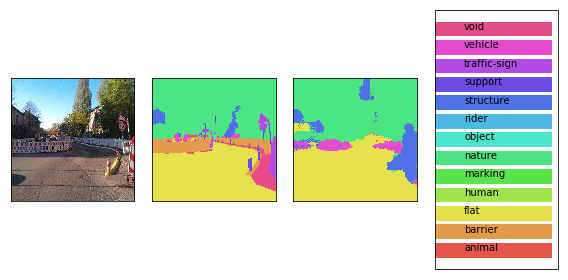

In [25]:
plot_prediction(image_filepath, predicted_image[0])

Hum, the model is now able to find a little bit more labels. Additionnally, the `flat` and `nature` pixels are closer to the ground-truth image. However the model predictions are far to be perfect...

We tried to run more training epochs, however we reached a learning plateau. So this possibility appears as unsufficient. Actually, some food for thought exists:
- how about tuning model hyperparameters (learning rate, for instance)?
- how about considering a bigger model?
- how about considering bigger images,  so as to reduce pixellization phenomenon?
- last but not least, how about considering more data?

Of course, the two last hypothesis are of first importance. Here we handled a toy dataset; no doubt that more interesting conclusions will be draw with the whole Mapillary dataset!

This notebook series is now over. You can try it on your own  and go further, with this small dataset or even with bigger and more interesting datasets! Do not hesitate to contact us (by mail: [infos+data@oslandia.com](mail:infos+data@oslandia.com), or via Github issues) if you want to exchange on the topic, or to contribute!